<center><img src="../meta/TRAIDENT.png" width="210"/></center>

# Baseline mode
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [182]:
zarrpath = "/idia/users/jdawson/transient/traident/datasets/obs-omcen/cubes/cube-1.zarr"
xrdata = xr.open_dataset(zarrpath, engine='zarr', chunks={})
cube = xrdata.cube

In [181]:
cube.chunks

((1,),
 (100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  44),
 (512, 512, 512, 512, 512, 512),
 (512, 512, 512, 512, 512, 512))

**Datasets:** /net/sinatra/vault2/oms/breifast-reference

In [231]:
try:
    if residual:
        del residual
except:
    residual = np.load('training_output/residuals_injected_omcen.npy')

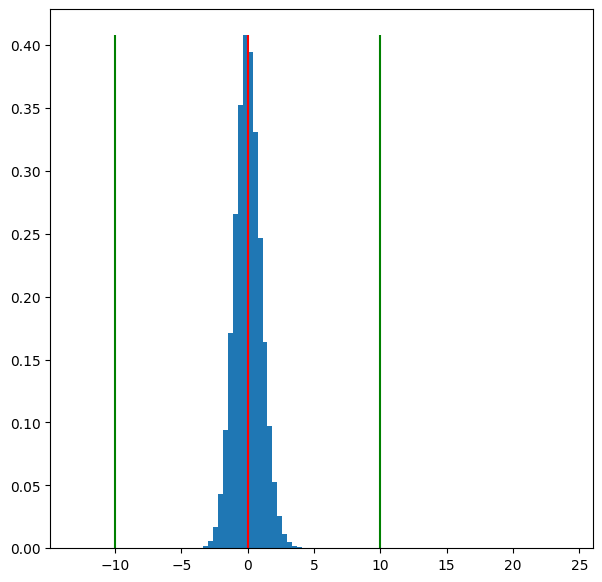

In [207]:
plt.close('all')
plt.figure(figsize=(7,7))
hist = plt.hist(residual.reshape(-1), bins=100, density=1)
plt.vlines(x=np.median(residual),ymin=0, ymax=hist[0].max(), color='r')
plt.vlines(x=np.median(residual) + 10*np.std(residual),ymin=0, ymax=hist[0].max(), color='g')
plt.vlines(x=np.median(residual) - 10*np.std(residual),ymin=0, ymax=hist[0].max(), color='g')

In [232]:
residual[residual > np.median(residual) + 5*np.std(residual)] = np.nan

In [233]:
residual[residual<0] = 0

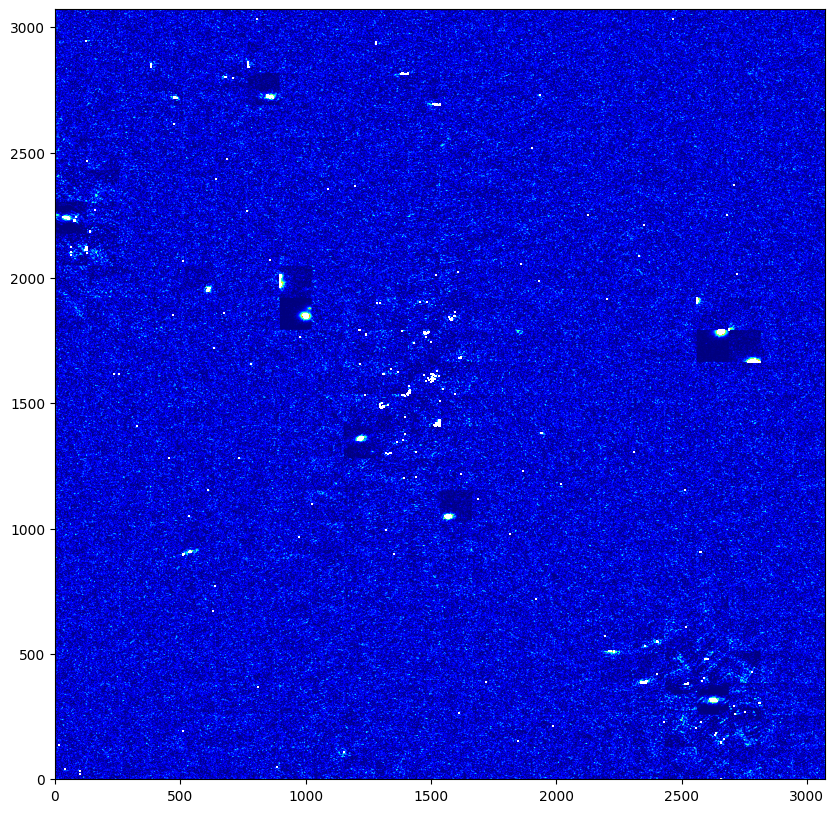

In [234]:
plt.close('all')
plt.figure(figsize=(10,10))
plt.imshow(residual, cmap='jet')
plt.gca().invert_yaxis()
# plt.colorbar()

In [215]:
outliers = np.where(residual > (np.median(residual) + 5*np.std(residual)))

In [211]:
outliers

(array([   1,   20,   30, ..., 2943, 3031, 3032]),
 array([2658,  100,  100, ...,  124,  806, 2465]))

In [212]:
np.save('training_output/outlier_positions_omcen.npy', outliers)

In [199]:
outlier_residual_value = residual[outliers]

(array([561., 427., 304., 155., 118.,  87.,  69.,  56.,  51.,  43.,  37.,
         17.,  19.,  22.,  16.,  15.,  12.,   3.,   9.,   5.,   4.,   3.,
          0.,   0.,   1.,   1.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 5.00269127,  5.38593864,  5.76918602,  6.1524334 ,  6.53568029,
         6.91892767,  7.30217505,  7.68542242,  8.06866932,  8.45191669,
         8.83516407,  9.21841145,  9.60165882,  9.9849062 , 10.36815357,
        10.75140095, 11.13464832, 11.5178957 , 11.90114307, 12.2843895 ,
        12.66763687, 13.05088425, 13.43413162, 13.817379  , 14.20062637,
        14.58387375, 14.96712112, 15.3503685 , 15.73361588, 16.11686325,
        16.50011063, 16.883358  , 17.26660538, 17.64985275, 18.03310013,
        18.4163475 , 18.79959488, 19.18284225, 19.56608772, 19.9493351 ,
        20.33258247, 20.71582985, 21.09907722, 21.4823246 , 21.86557198,
 

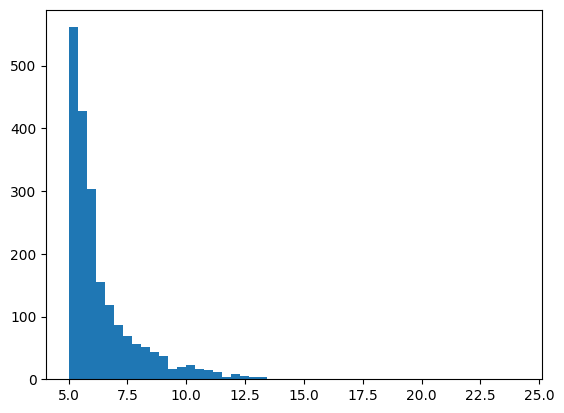

In [200]:
plt.figure()
plt.hist(outlier_residual_value, bins=50)

In [193]:
residual[1536,1536]

-0.22795035

In [219]:
len(outliers[0])

2040

(0.0, 3072.0)

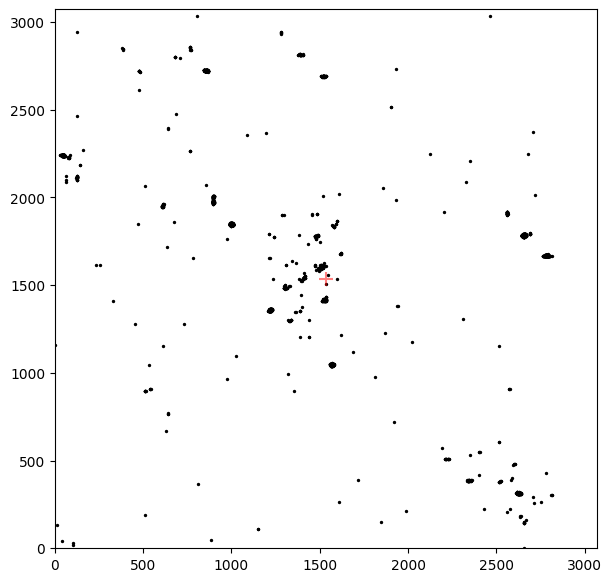

In [235]:
outliers = np.where(residual != residual)
plt.figure(figsize=(7,7))
plt.scatter(outliers[1], outliers[0], c='k', s=2)
plt.scatter(3072/2, 3072/2, c='r', s=100, marker='+',alpha=0.5)
plt.xlim(0,3072)
plt.ylim(0,3072)

In [70]:
outlier_timeseries = np.load("training_output/outlier_timeseries.npy")
outlier_coords = np.load("training_output/outlier_coordinates.npy")

In [129]:
outlier_timeseries.shape

(859, 3644)

In [176]:
np.where(outlier_coords == np.array([1148,  504]))

(array([315, 316, 316]), array([1, 0, 1]))

(0.0, 3072.0)

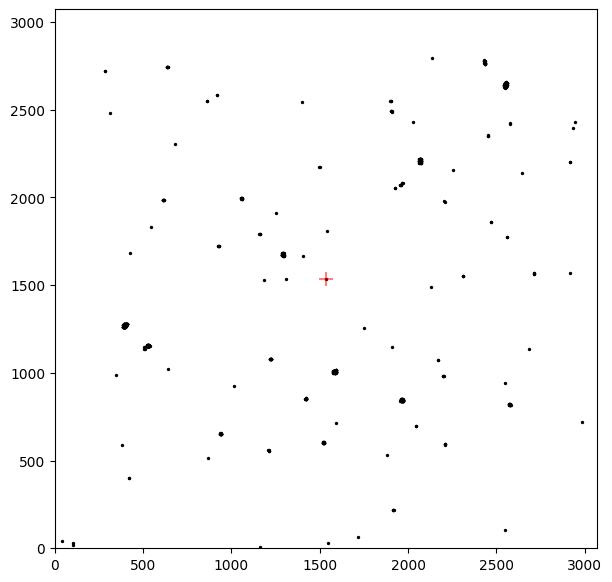

In [74]:
plt.figure(figsize=(7,7))
plt.scatter(outlier_coords[:,1], outlier_coords[:,0], c='k', s=2)
plt.scatter(3072/2, 3072/2, c='r', s=100, marker='+',alpha=0.5)
plt.xlim(0,3072)
plt.ylim(0,3072)

In [119]:
def fft_autocorr_chunk(chunk):
    # Zero-pad to 2*T for full autocorr
    T, H = chunk.shape
    n = 2 * T
    # FFT along time axis
    fft_chunk = np.fft.fft(chunk, n=n, axis=0)
    # Power spectrum
    power = np.abs(fft_chunk)**2
    # IFFT to get autocorrelation
    ac_full = np.fft.ifft(power, axis=0).real
    # Normalize and return only positive lags
    return ac_full[:T]

In [138]:
autocorrs = fft_autocorr_chunk(outlier_timeseries.T)

In [141]:
autocorrs[0,:] = 0

In [142]:
autocorrs.shape

(3644, 859)

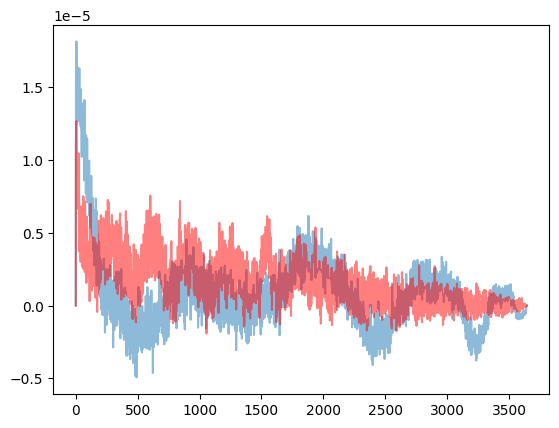

In [177]:
plt.figure()
plt.plot(autocorrs[:,315], alpha=0.5)
plt.plot(autocorrs[:,632], 'r-', alpha=0.5)
# plt.plot(np.max(autocorrs[:,5:], 0))

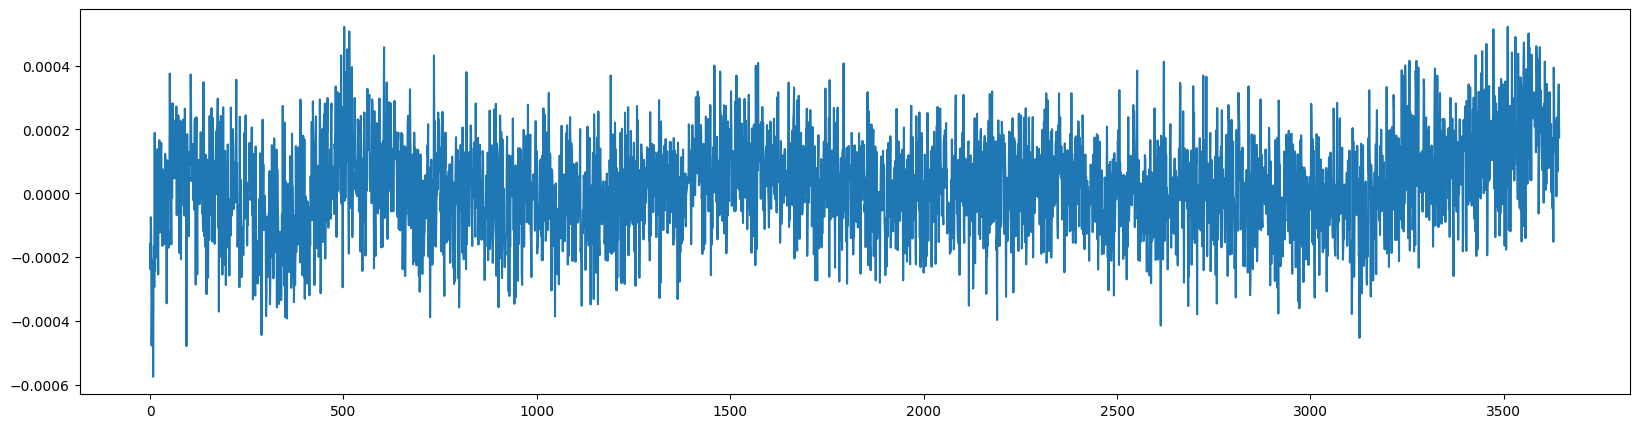

In [178]:
plt.figure(figsize=(20,5))
plt.plot(outlier_timeseries[315,:])

In [147]:
from sklearn.decomposition import PCA

In [148]:
def runPCAAnomalies(inputs, n_components=2):
    pca = PCA(n_components=n_components)
    pca.fit(inputs)
    PCA_dims = pca.transform(inputs)
    return pca, PCA_dims

In [151]:
pca, PCA_dims = runPCAAnomalies(autocorrs.T)

In [152]:
PCA_dims.shape

(859, 2)

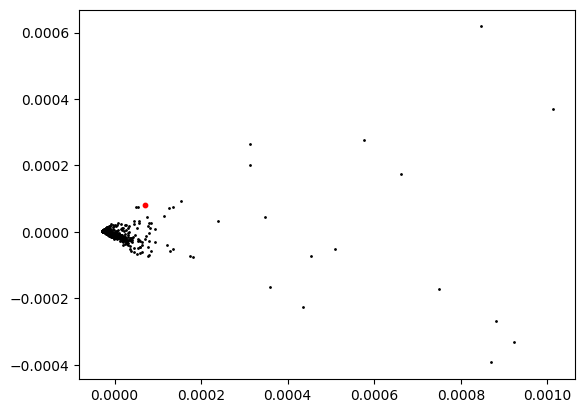

In [179]:
plt.close('all')
plt.figure()
plt.scatter(PCA_dims[:,0], PCA_dims[:,1], c='k', s=1)
plt.scatter(PCA_dims[632,0], PCA_dims[632,1], c='r', s=10)

In [155]:
pca_dists = np.sum(PCA_dims**2, 1)
print(pca_dists.shape)

(859,)


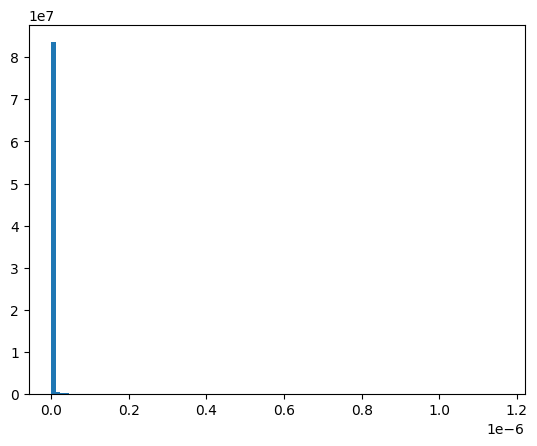

In [159]:
plt.figure()
hist = plt.hist(pca_dists, bins=100)

In [171]:
indices = np.argsort(pca_dists)
sorted_coords = outlier_coords[indices][::-1]

In [173]:
np.where(sorted_coords == [1536, 1536])

(array([25, 25]), array([0, 1]))